In [ ]:
# Jupyter WebでR　１年生薬学概論用

# Jupyter Webにアクセス

# https://jupyter.org/try
# “Try Jupyter with R”をクリック、しばらく待つ
# File → New Notebook → R

In [1]:
# Rを電卓のように使ってみる

1 + 2  # Shift+Return

[1] 3

In [2]:
2 * 3

[1] 6

In [3]:
2 ^ 4  # 2*2*2*2

[1] 16

In [4]:
2 ^ 50

[1] 1.1259e+15

In [5]:
sqrt(2)

[1] 1.414214

In [6]:
log(10)  # ln10

[1] 2.302585

In [7]:
log10(100)  # log100

[1] 2

In [8]:
# Rで統計

a <- c(2, 3, 4, 5, 6, 7, 8)

In [9]:
a

[1] 2 3 4 5 6 7 8

In [10]:
a <- a * 10

In [11]:
a

[1] 20 30 40 50 60 70 80

In [12]:
sum(a)

[1] 350

In [13]:
mean(a)

[1] 50

In [14]:
sd(a)

[1] 21.60247

In [15]:
b <- c(47, 48, 49, 50, 51, 52, 53)

In [16]:
b

[1] 47 48 49 50 51 52 53

In [17]:
mean(b)

[1] 50

In [18]:
sd(b)

[1] 2.160247

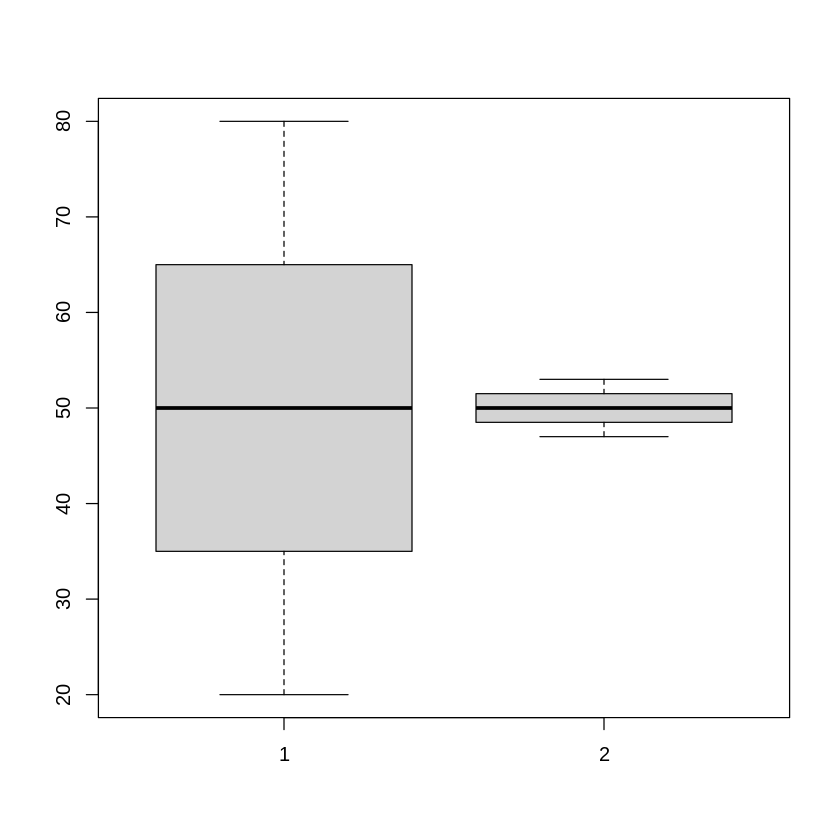

In [19]:
boxplot(a, b)

In [20]:
# 1-コンパートメントモデルに基づく解析　経口投与　Jupyter用

time1 <- c(1, 2, 3, 4, 6, 8, 12)
conc1 <- c(22.3, 17.2, 15.1, 12.6, 5.7, 3.6, 1.2, 6.6, 10.3, 14.8, 10.4, 8.5, 7.1, 2.4)
eqid1 <- c(1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2)
dat <- data.frame(time1, conc1, eqid1)
names(dat)<-c('Time', 'Conc', 'Eqid')
print(dat)

   Time Conc Eqid
1     1 22.3    1
2     2 17.2    1
3     3 15.1    1
4     4 12.6    1
5     6  5.7    1
6     8  3.6    1
7    12  1.2    1
8     1  6.6    2
9     2 10.3    2
10    3 14.8    2
11    4 10.4    2
12    6  8.5    2
13    8  7.1    2
14   12  2.4    2


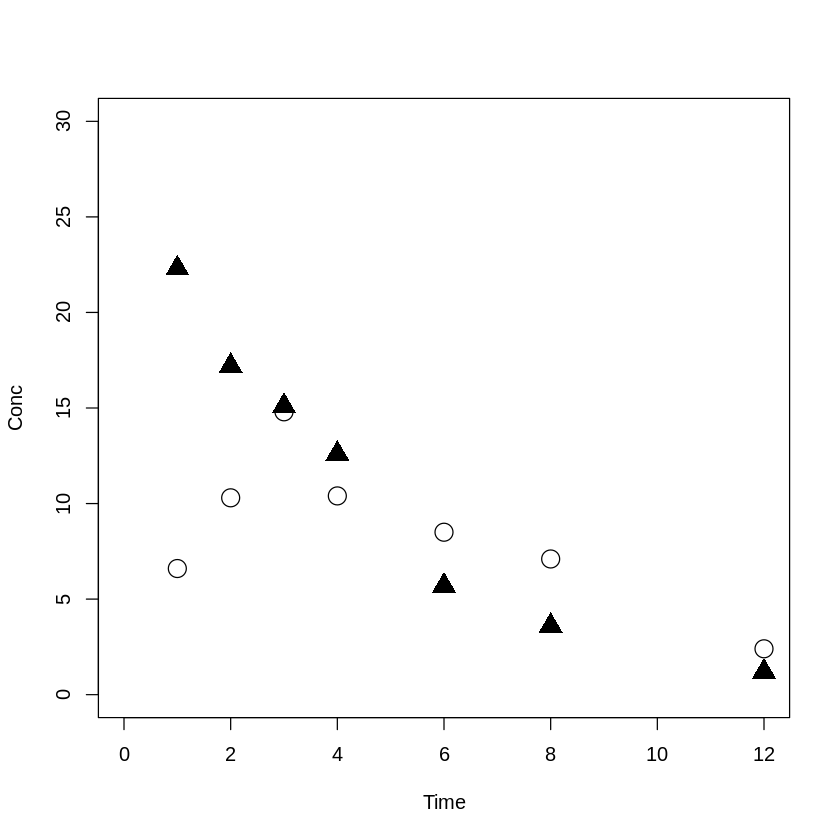

In [21]:
plot(dat[,1], dat[,2], pch=ifelse(dat[,3]==1,17,1), cex=2, xlim=c(0,12), ylim=c(0,30), xlab='Time', ylab='Conc')

In [22]:
install.packages("minpack.lm")
library(minpack.lm)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [23]:
# C = Dose/Vd * exp(–(CL/Vd)*t)  急速静注のとき
# C = (ka•F•Dose/(CL–ka•Vd))*{exp(–ka*t)–exp(–(CL/Vd)*t)}  経口投与のとき
# p[1] = ka, p[2] = F, p[3] = CL, p[4] = Vd, Dose = 100

func <- function(p, x, flag){
	y1=100/p[4]*exp(-p[3]/p[4]*x)
	y2=100*p[1]*p[2]/(p[3]-p[1]*p[4])*(exp(-p[1]*x)-exp(-p[3]/p[4]*x))
	c <- cbind(y1, y2)
	diag(c[,flag])
}
res <- function(p, data){
	data[,2]-func(p, data[,1], data[,3])
}
optimize <- function(p, data){
	nls.lm(par=p, fn=res, data=data, control=nls.lm.control(maxiter=1000))
}

In [24]:
param <- c(0.8, 0.5, 0.3, 2)
result <- optimize(param, dat)

In [25]:
print(result)

Nonlinear regression via the Levenberg-Marquardt algorithm
parameter estimates: 0.421278849336552, 0.873536982596186, 0.832017932269686, 3.46368026184571 
residual sum-of-squares: 18.03
reason terminated: Relative error in the sum of squares is at most `ftol'.


[1] 22.705936 17.857334 14.044097 11.045135  6.831648  4.225517  1.616548
 [8]  7.643026 11.026350 11.962940 11.568060  9.199627  6.570556  2.911415

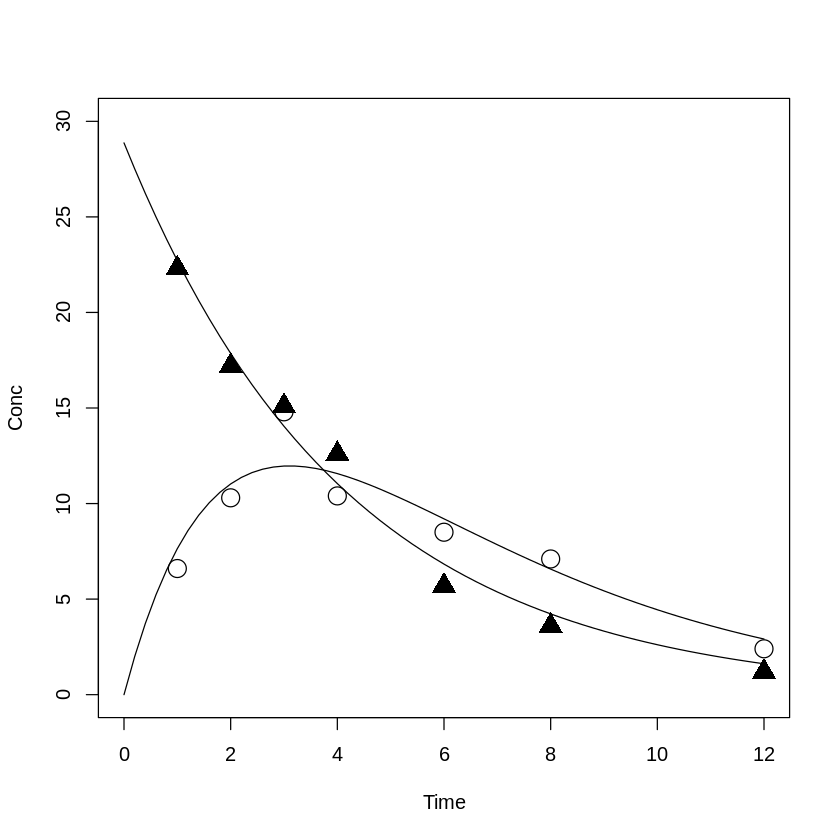

In [26]:
func(coef(result), dat[,1], dat[,3])
plot(dat[,1], dat[,2], pch=ifelse(dat[,3]==1,17,1), cex=2, xlim=c(0,12), ylim=c(0,30), xlab='Time', ylab='Conc')
time <- seq(0, 12, 0.2)
lines(time, func(coef(result), time, rep(1,length(time))))
lines(time, func(coef(result), time, rep(2,length(time))))

In [27]:
# RでPK解析Simulation

# mrgsolveパッケージをインストール
install.packages("mrgsolve")
library(mrgsolve)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘RcppArmadillo’



Attaching package: ‘mrgsolve’


The following object is masked from ‘package:stats’:

    filter




In [28]:
# 1-コンパートメントモデル経口投与
code<-" 
$PARAM
Ke = 0.15, Vd = 10, Ka = 0.8
$INIT
Xa=10, X=0
$ODE
dxdt_Xa = -Ka*Xa;
dxdt_X = Ka*Xa - Ke*X;
$CAPTURE
C = X/Vd; "

Building oral ... 
done.



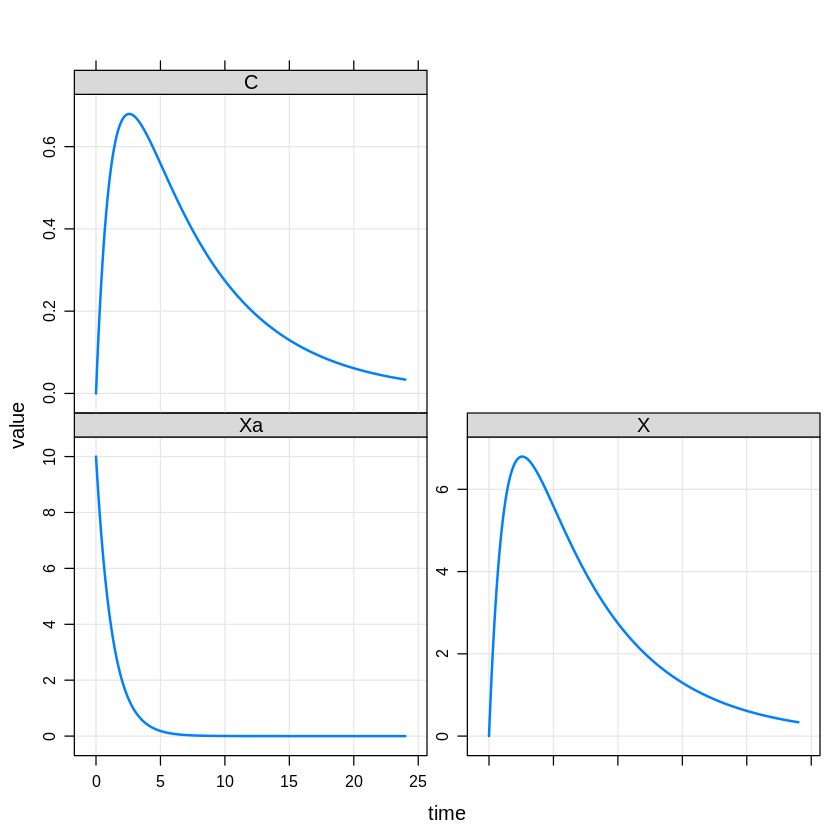

In [29]:
# グラフを描く
mod<-mcode("oral", code) %>% update(end = 24, delta = 0.1)
mod %>% mrgsim %>% plot

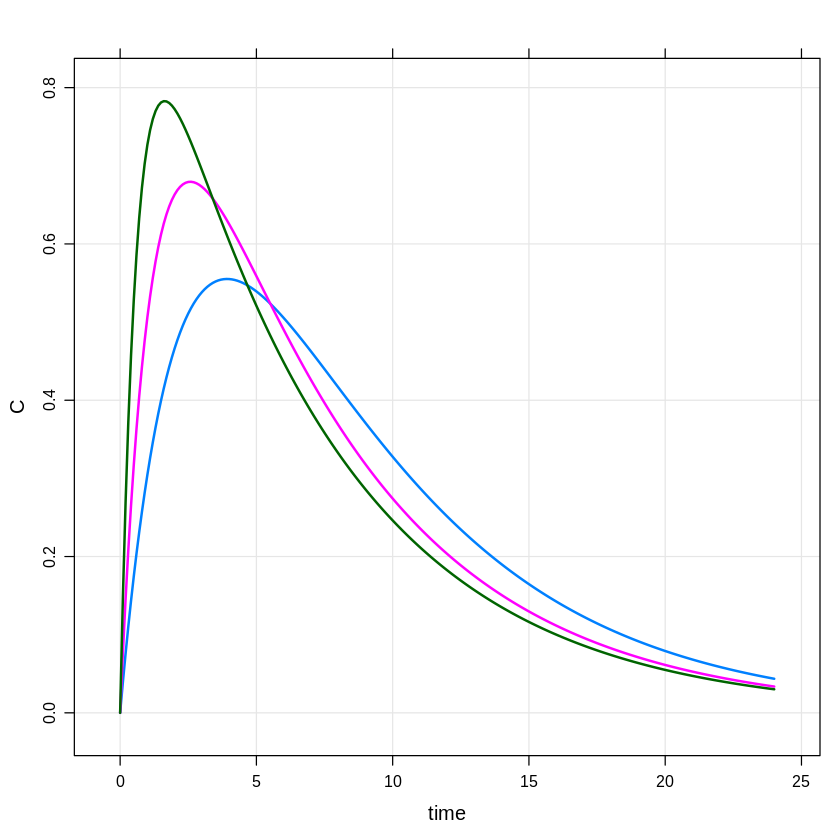

In [30]:
# Kaを変化させてみる
idataka <- expand.idata(Ka = c(0.4, 0.8, 1.6))
out <- 
  mod %>% 
  idata_set(idataka) %>% 
  mrgsim(end=24)
plot(out, C~time)

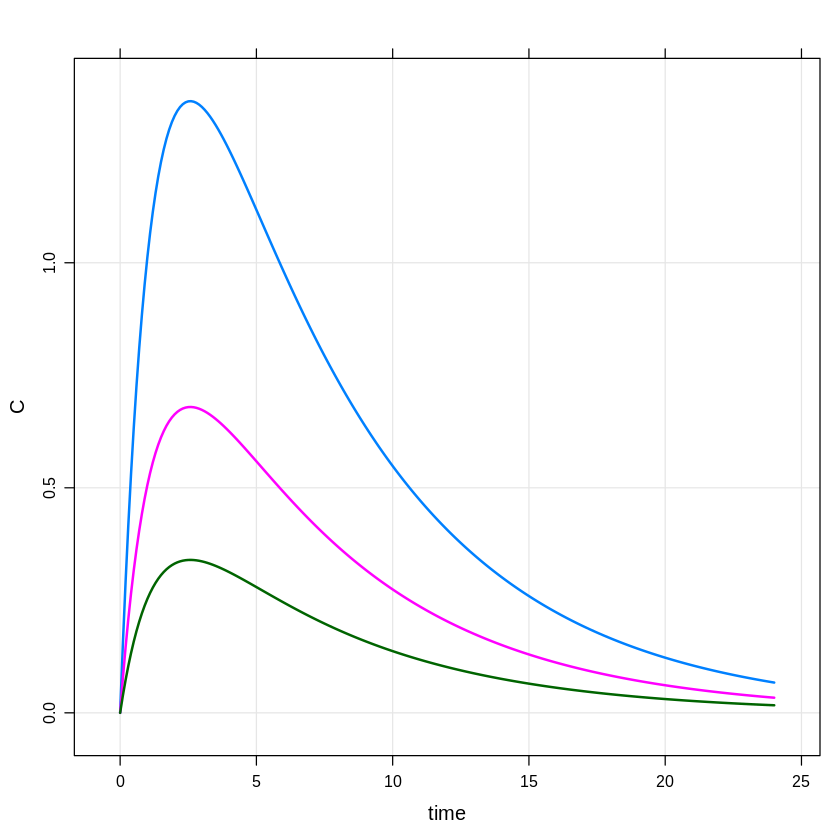

In [31]:
# Vdを変化させてみる
idatavd <- expand.idata(Vd = c(5, 10, 20))
out <- 
  mod %>% 
  idata_set(idatavd) %>% 
  mrgsim(end=24)
plot(out, C~time)

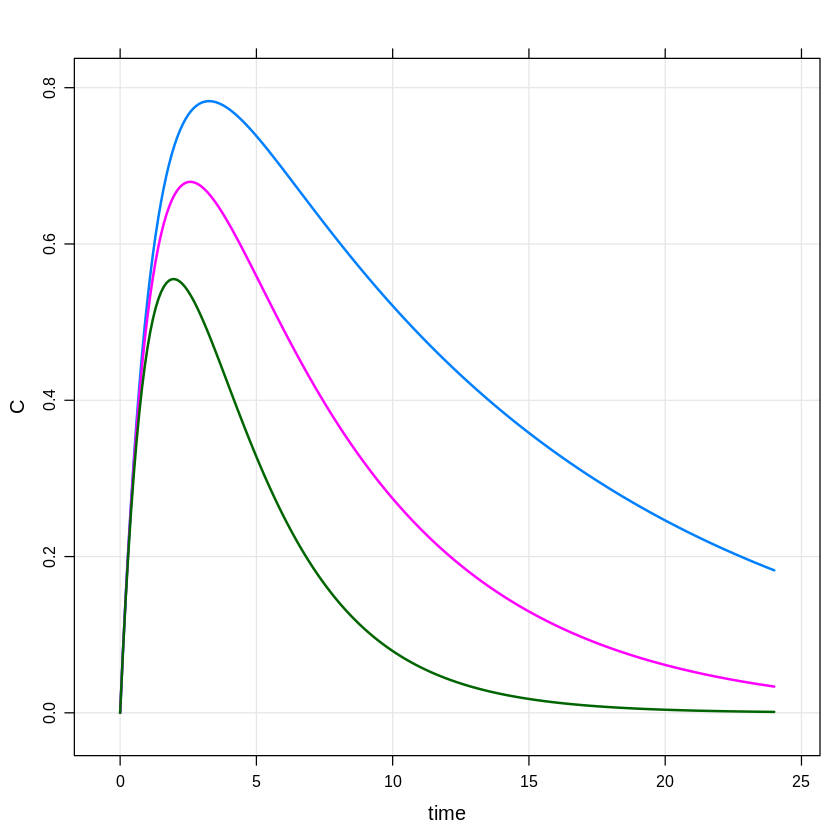

In [32]:
# Keを変化させてみる
idatake <- expand.idata(Ke = c(0.075, 0.15, 0.3))
out <- 
  mod %>% 
  idata_set(idatake) %>% 
  mrgsim(end=24)
plot(out, C~time)

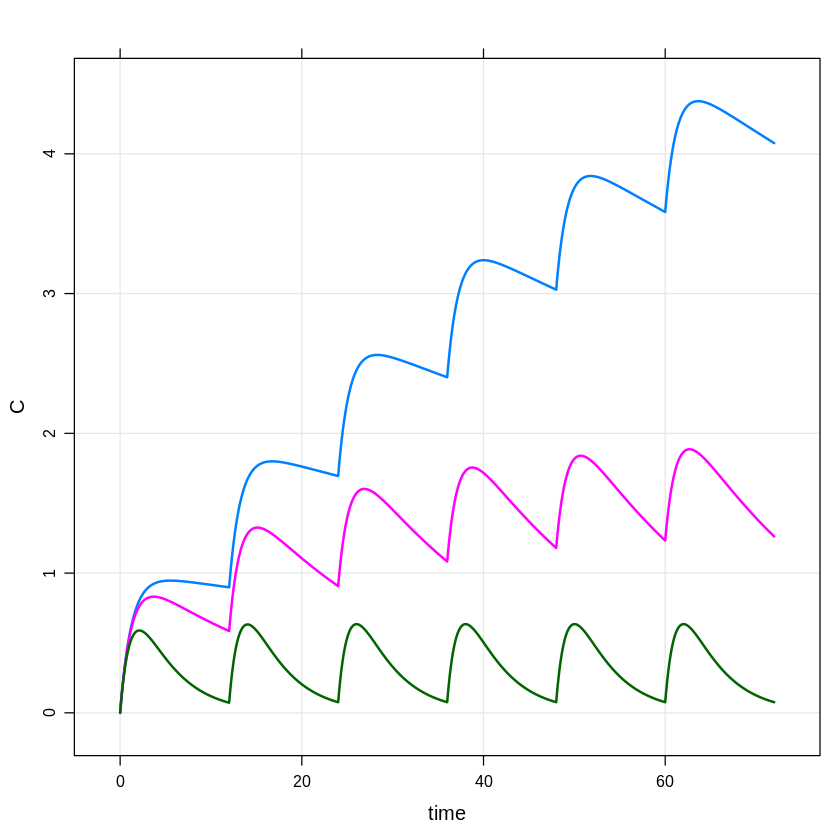

In [33]:
# Keが異なる患者へ12時間ごと10 mg繰り返し投与3日間
idatake <- expand.idata(Ke = c(0.01, 0.05, 0.25))
mod %>% init(Xa=0) %>%
  ev_rx("10 q 12 x 6") %>%
  idata_set(idatake) %>% 
  mrgsim(end = 72, delta = 0.1) %>% 
  plot(C~time)

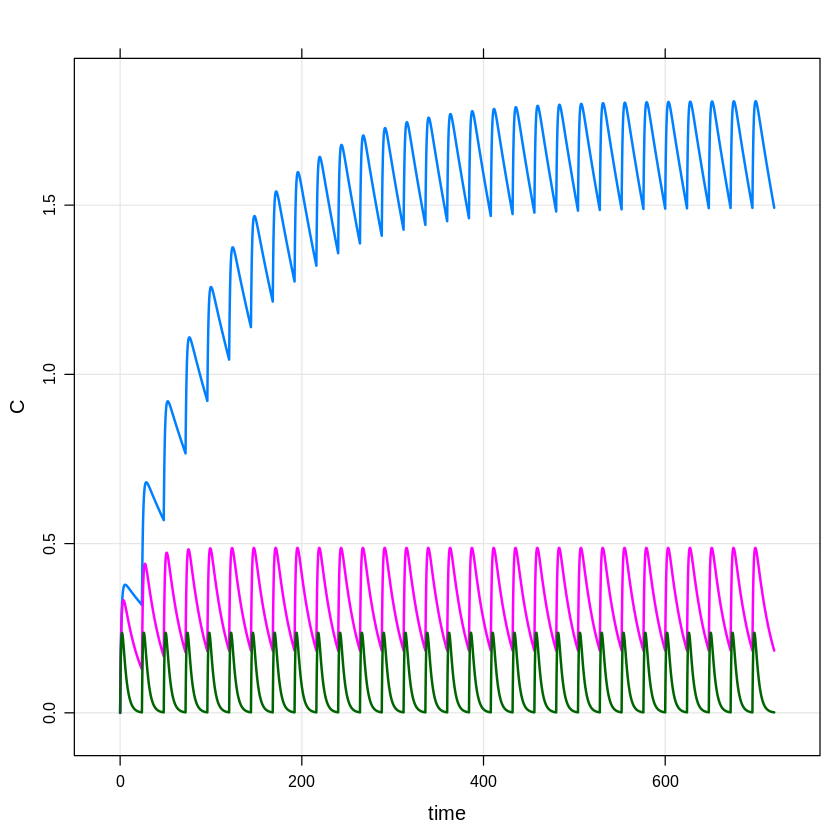

In [34]:
# Keが異なる患者へ24時間ごと4 mg繰り返し投与30日間
idatake <- expand.idata(Ke = c(0.01, 0.05, 0.25))
mod %>% init(Xa=0) %>%
  ev_rx("4 q 24 x 30") %>%
  idata_set(idatake) %>% 
  mrgsim(end = 720, delta = 0.1) %>% 
  plot(C~time)

In [35]:
# Ka、Ke、Vdなどの数字を変えて試してみてください
# 終了するときは、ブラウザ（のタブ）を閉じてください。何も保存されません
# 保存したいときは、次のようにしてください
# File → Rename → 「R-PK」など名前をつける
# File → Download as → Notebook　としてダウンロード
# 便利な使い方
# グーグルコラボにアクセスする
# https://colab.research.google.com
# グーグルのアカウント（Gmailアドレスとパスワード）でログインする
# ファイル→ファイルをアップロード　先ほどダウンロードしたファイルをアップロード
# グーグルコラボ上で実行でき、保存もできます